## 读取数据集

In [10]:
import os
os.makedirs(os.path.join('..', 'data'), exist_ok=True)      # 用于递归创建目录。
data_file = os.path.join('..', 'data', 'house_tiny.csv')    # 将多个路径组合后返回
with open(data_file, 'w') as f:                         #   自动调用close关闭文件
    f.write('NumRooms,Alley,Price\n') # 列名
    f.write('NA,Pave,127500\n') # 每⾏表⽰⼀个数据样本
    f.write('2,NA,106000\n')
    f.write('4,NA,178100\n')
    f.write('NA,NA,140000\n')

In [11]:
import pandas as pd
data = pd.read_csv(data_file)
print(data)


   NumRooms Alley   Price
0       NaN  Pave  127500
1       2.0   NaN  106000
2       4.0   NaN  178100
3       NaN   NaN  140000


## 处理缺失值

In [12]:
inputs, outputs = data.iloc[:, 0:2], data.iloc[:, 2]        #   拆分出输入与输出
inputs = inputs.fillna(inputs.mean())                   #   替换缺失值
inputs

C:\Users\WZH\AppData\Local\Temp\ipykernel_6188\3277229751.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  inputs = inputs.fillna(inputs.mean())                   #   替换缺失值


,NumRooms,Alley
0,3.0,Pave
1,2.0,NaN
2,4.0,NaN
3,3.0,NaN


In [13]:
inputs = pd.get_dummies(inputs, dummy_na=True)
print(inputs)

   NumRooms  Alley_Pave  Alley_nan
0       3.0           1          0
1       2.0           0          1
2       4.0           0          1
3       3.0           0          1


In [14]:
import torch
X, y = torch.tensor(inputs.values), torch.tensor(outputs.values)
X, y

(tensor([[3., 1., 0.],
         [2., 0., 1.],
         [4., 0., 1.],
         [3., 0., 1.]], dtype=torch.float64),
 tensor([127500, 106000, 178100, 140000]))

# 线性神经网络

## 线性回归
依照房屋的面积和房龄来估算房屋价格
每行数据为**样本**
预测的价格为**标签（label）或⽬标（target）**
预测所依据的⾃变量（⾯积和房龄）称为**特征（feature）或协变量（covariate）**

## 线性回归从零开始实现

In [15]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 生成数据集

In [16]:
def synthetic_data(w, b, num_examples): #@save
    """⽣成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])


features: tensor([-0.8114, -0.8569]) 
label: tensor([5.4861])


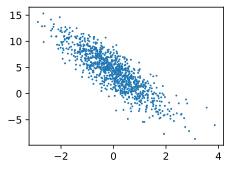

In [17]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集

In [18]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [19]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.4933, -0.6682],
        [-0.5780, -1.0709],
        [ 0.1742,  2.1995],
        [-2.3423, -1.8462],
        [-0.3090, -0.9365],
        [ 0.1314, -2.3342],
        [-0.1518, -1.7792],
        [-0.4045,  1.1296],
        [ 0.5534, -2.0020],
        [-1.5274, -0.3457]]) 
 tensor([[ 7.4570],
        [ 6.6722],
        [-2.9284],
        [ 5.7946],
        [ 6.7636],
        [12.3805],
        [ 9.9281],
        [-0.4502],
        [12.1107],
        [ 2.3236]])


In [20]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [21]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b
def squared_loss(y_hat, y): #@save
    """均⽅损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
def sgd(params, lr, batch_size): #@save
    """⼩批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [22]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [23]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的⼩批量损失
        # 因为l形状是(batch_size,1)，⽽不是⼀个标量。l中的所有元素被加到⼀起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使⽤参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.044775
epoch 2, loss 0.000180
epoch 3, loss 0.000050


In [24]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-8.7261e-05, -3.4642e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([5.7697e-05], grad_fn=<RsubBackward1>)


### 线性回归的简洁实现

In [25]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [27]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造⼀个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[ 0.4866, -0.1731],
         [-0.3723,  0.2608],
         [-1.8124,  0.8626],
         [ 0.5408,  0.3218],
         [-0.2514,  1.5418],
         [-1.2823,  0.2485],
         [-0.1978, -0.4081],
         [ 0.1111,  2.0413],
         [ 2.1549,  0.2723],
         [ 1.4384, -0.0199]]),
 tensor([[ 5.7608],
         [ 2.5757],
         [-2.3449],
         [ 4.1801],
         [-1.5655],
         [ 0.8000],
         [ 5.1733],
         [-2.5145],
         [ 7.5812],
         [ 7.1251]])]

In [30]:
from torch import nn
net = nn.Sequential(nn.Linear(2,1))
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [31]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()        #   反向传播
        trainer.step()      #   更新参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000319
epoch 2, loss 0.000106
epoch 3, loss 0.000105


## 图像分类数据集

In [32]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

In [33]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0〜1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
root="../data", train=False, transform=trans, download=True)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [34]:
len(mnist_train), len(mnist_test)


(60000, 10000)

In [40]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

RuntimeError: grad can be implicitly created only for scalar outputs

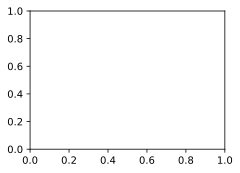

In [41]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)